In [1]:
import os
import pandas as pd
import numpy as np
# from sklearn import linear_model
from scipy.stats import zscore
# import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
# import prol
import math
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stats
import seaborn as sns
from treeple.ensemble import PatchObliqueRandomForestRegressor
from sklearn.metrics import r2_score

In [2]:
print(os.getcwd())
data = np.load('group_data_natview_data_fmri_eyetracking1hz.npy',allow_pickle=True)
data_dict = data.item()

/Users/qinazihan/Documents/JHU Research Lab/Jovo/Nov20


In [3]:
subjects = data_dict['subjects']
sessions = data_dict['sessions']
tasks = data_dict['tasks']
data_brainstates = data_dict['data_fmri']
data_eyetracking = data_dict['data_eyetracking']
brainstates = [ 'tsCAP1', 'tsCAP2', 'tsCAP3', 'tsCAP4', 'tsCAP5', 'tsCAP6', 'tsCAP7', 'tsCAP8']

In [4]:
def Data_Handeler(sub, session, state, task, window=12, mask_thr=0.75):
    key = 'sub-' + sub + '_ses-' + session + '_task-' + task
    fmri_ts_mask = (data_brainstates[key]['tsMask'].to_numpy() > 0.5)
    eyetrack_mask = (data_eyetracking[key]['tmask'].to_numpy() > 0.5)

    FMRI_TARGET_DATA = data_brainstates[key][state].to_numpy()
    time_fmri = data_brainstates[key]['time'].to_numpy()
    PD_DATA = data_eyetracking[key]['pupil_size'].to_numpy()
    Xpos = data_eyetracking[key]['X_position'].to_numpy()
    Ypos = data_eyetracking[key]['Y_position'].to_numpy()

    PD_DATA_dfirst = np.diff(PD_DATA, prepend=PD_DATA[0])
    PD_DATA_dsecond = np.diff(PD_DATA, n=2, prepend=PD_DATA_dfirst[:2])
    PREDICTION_FEATURES = np.vstack((PD_DATA, PD_DATA_dfirst, PD_DATA_dsecond)).T

    PUPIL = []
    FMRI = []
    TIME = []
    for i in range(0, FMRI_TARGET_DATA.shape[0] - window):
        X = np.reshape(PREDICTION_FEATURES[(i):(i + window), :].flatten(), (1, -1))
        FEATURE_MASK = eyetrack_mask[(i):(i + window)]
        Y = FMRI_TARGET_DATA[i + window]
        TARGET_MASK = fmri_ts_mask[i + window]
        if np.mean(FEATURE_MASK) >= 0.75 and TARGET_MASK:
            PUPIL.append(X)
            FMRI.append(Y)
            TIME.append(time_fmri[i + window])
    PUPIL_DF = np.concatenate(PUPIL)
    return PUPIL_DF, FMRI, TIME


In [5]:
# Time Encoding
import torch
import torch.nn as nn

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super(TimeEmbedding, self).__init__()
        self.freqs = (2 * np.pi) / (torch.arange(2, dim + 1, 2))
        self.freqs = self.freqs.unsqueeze(0)

    def forward(self, t):
        self.sin = torch.sin(self.freqs * t)
        self.cos = torch.cos(self.freqs * t)
        return torch.cat([self.sin, self.cos], dim=-1)

def Time_Handeler(t,tdim= 50):
    time_embed = TimeEmbedding(dim=tdim)
    timeembed = []
    for i in range(len(t)):
        timeembed.append(time_embed(t[i]))
    return np.concatenate(timeembed).reshape(-1,tdim)

In [6]:
def Train_Test(test_sub,SUBJECTS,session,state,tasks_list, time = False,model = 'ridge'):
    PUPIL_ALL = []
    FMRI_ALL = []
    TIME_ALL = []
    for sub_i in SUBJECTS:
        for task in tasks_list:
            PUPIL,FMRI,TIME = Data_Handeler(sub = sub_i,session =session,state = state,task = task,window=12,mask_thr = 0.75)
            if sub_i == test_sub:
                PUPIL_TEST = zscore(PUPIL,axis=1)
                FMRI_TEST = zscore(FMRI)
                TIME_TEST = TIME
            else:
                PUPIL_ALL.append(PUPIL)
                FMRI_ALL.extend(FMRI)
                TIME_ALL.extend(TIME)

    PUPIL_TRAIN = zscore(np.concatenate(PUPIL_ALL),axis = 1)
    FMRI_TRAIN = zscore(FMRI_ALL)
    TIME_TRAIN = TIME_ALL
    if model == 'ridge':
        reg = Ridge(alpha=1)    
    if model == 'rf':
        reg = RandomForestRegressor()
    if model == 'morf':
        reg = PatchObliqueRandomForestRegressor()
    if time:
        TIME_ENCODE_TRAIN = Time_Handeler(TIME_TRAIN)
        # print(TIME_ENCODE_TRAIN.shape)
        PUPIL_TRAIN_TIME = np.hstack((PUPIL_TRAIN,TIME_ENCODE_TRAIN))
        # print(PUPIL_TRAIN_TIME.shape)
        TIME_ENCODE_TEST = Time_Handeler(TIME_TEST)
        PUPIL_TEST_TIME = np.hstack((PUPIL_TEST,TIME_ENCODE_TEST))
    else:
        PUPIL_TRAIN_TIME = PUPIL_TRAIN
        PUPIL_TEST_TIME = PUPIL_TEST
    print(PUPIL_TRAIN_TIME.shape)
    reg.fit(PUPIL_TRAIN_TIME, FMRI_TRAIN)
    ypred_train = reg.predict(PUPIL_TRAIN_TIME)
    ypred = reg.predict(PUPIL_TEST_TIME)
    corr = np.corrcoef(np.array(FMRI_TEST).T,ypred.T)[0,1]
    return FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr

In [7]:
session = '01'
state = 'tsCAP5'
CORR = [] 
CORR_TIME = []
R2_score = []
R2_score_TIME = []
SUBJECTS = ['01', '02','03','04', '05','06', '07', '08', '09','10','11','12', '13', '14', '15', '16', '18', '20', '21', '22']
available_subjects = []
tasks_list = ['rest_run-01']
for subject in SUBJECTS:
    key = 'sub-' + subject+'_ses-'+session +'_task-'+ tasks_list[0]
    if key in data_brainstates.keys():
        available_subjects.append(subject)
        
for test_sub in available_subjects:
    print(test_sub)
    _,_,FMRI_TEST,ypred,corr = Train_Test(test_sub,available_subjects,session,state,tasks_list,time = False,model = 'ridge')
    R2_score.append(r2_score(FMRI_TEST,ypred))
    CORR.append(corr)
    _,_,FMRI_TEST_time,ypred_time,corr_time = Train_Test(test_sub,available_subjects,session,state,tasks_list,time = True,model = 'ridge')
    CORR_TIME.append(corr_time)
    R2_score_TIME.append(r2_score(FMRI_TEST_time,ypred_time))
    print(corr,corr_time)
    print(r2_score(FMRI_TEST,ypred),r2_score(FMRI_TEST_time,ypred_time))
    

01
(7179, 36)
(7179, 86)
0.2701033422719736 -0.02487489564960708
0.05131935742685956 -0.07161990189051015
02
(6777, 36)
(6777, 86)
0.4632863323530008 0.4321426687630062
0.19207753715744258 0.14937037052265023
04
(6728, 36)
(6728, 86)
0.09900947082002463 -0.15450573414689586
0.007728939544411895 -0.12015721839710936
06
(6774, 36)
(6774, 86)
0.3611513324446496 0.35854796740463574
0.11642176258267012 0.1255320451785119
07
(6774, 36)
(6774, 86)
0.13748936452680383 0.09948158240132222
0.017602965761200906 -0.013140864317005008
08
(6889, 36)
(6889, 86)
0.3503462340447063 0.37191506353097475
0.12091757374424517 0.1380696940052103
09
(7265, 36)
(7265, 86)
0.28653521794431236 0.04739543378659551
0.07106184447710662 -0.12963185051973847
12
(6728, 36)
(6728, 86)
0.41015225142740935 0.38252651662018183
0.09973377442048204 0.12025455517100347
13
(6745, 36)
(6745, 86)
0.27018800369755974 0.300318400825497
-0.043491683827404204 -0.026090213137159646
14
(6737, 36)
(6737, 86)
0.01143379449877143 -0.078

18
(6826, 36)
0.3296891723863122


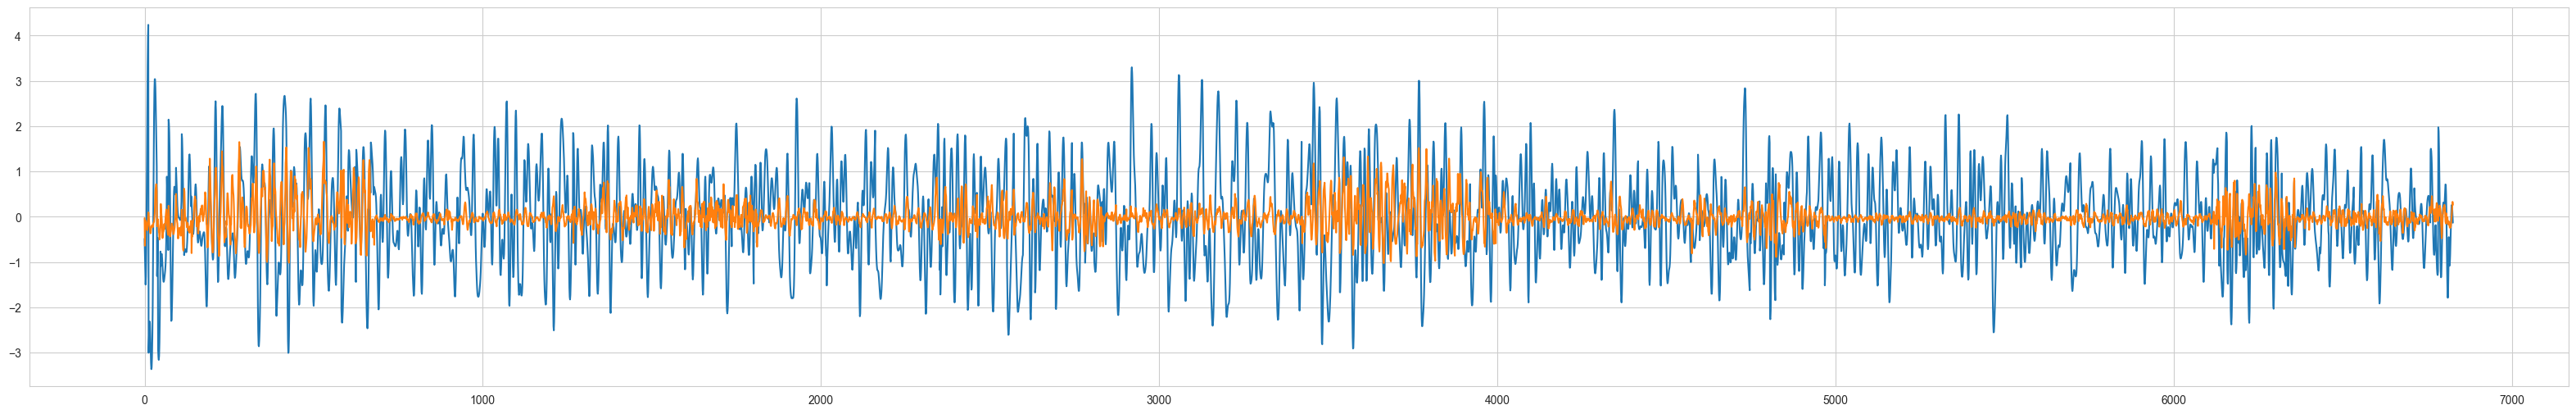

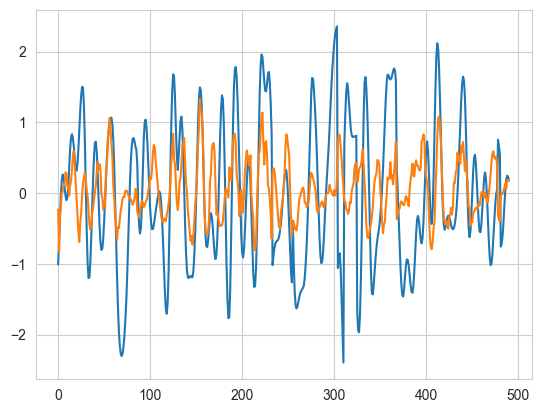

(6826, 86)
0.2943513393602558


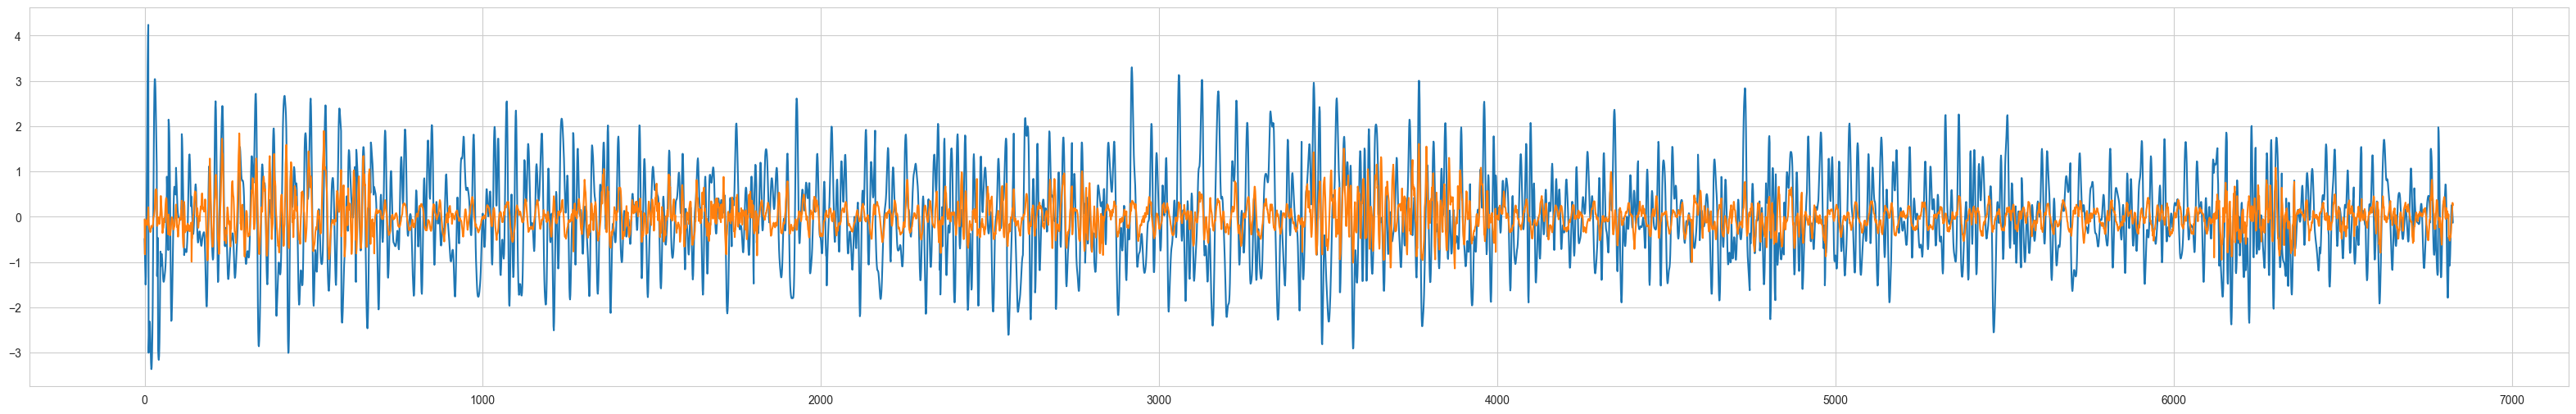

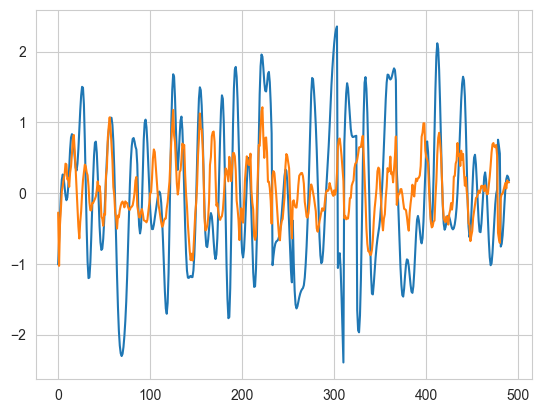

In [8]:
TEST_SUB = np.random.choice(available_subjects)

for test_sub in [TEST_SUB]:
    plt.figure(figsize=(40, 6))
    print(test_sub)
    FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr = Train_Test(TEST_SUB,available_subjects,session,state,tasks_list,time = False,model = 'ridge')
    print(corr)
    plt.plot(FMRI_TRAIN)
    plt.plot(ypred_train)
    plt.show()
    plt.plot(FMRI_TEST)
    plt.plot(ypred)
    plt.show()
    
    plt.figure(figsize=(40, 6))
    FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr = Train_Test(TEST_SUB,available_subjects,session,state,tasks_list,time = True,model = 'ridge')
    print(corr)
    plt.plot(FMRI_TRAIN)
    plt.plot(ypred_train)
    plt.show()
    plt.plot(FMRI_TEST)
    plt.plot(ypred)
    plt.show()

Text(0.5, 1.0, 'Ridge Regression Correlation rest_run-01')

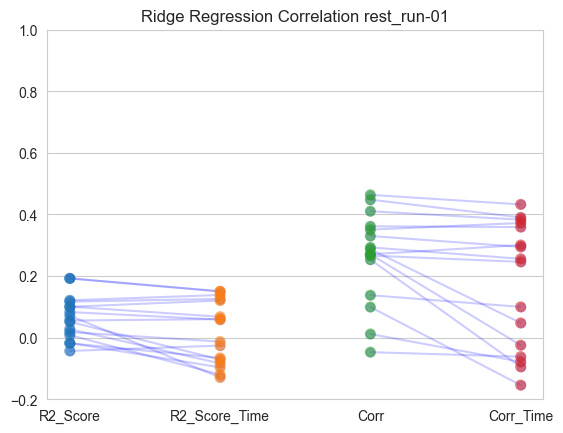

In [9]:
CORR_Ridge = pd.DataFrame(np.hstack((np.array(R2_score).reshape(-1,1),np.array(R2_score_TIME).reshape(-1,1),np.array(CORR).reshape(-1,1),np.array(CORR_TIME).reshape(-1,1))),columns = ['R2_Score','R2_Score_Time','Corr','Corr_Time'])
sns.stripplot(CORR_Ridge,s = 8,alpha = 0.6,jitter = False)
for idx, row in CORR_Ridge.iterrows():
    plt.plot([2, 3], [row['Corr'], row['Corr_Time']], color='blue', linestyle='-', marker='o',alpha = 0.2)
for idx, row in CORR_Ridge.iterrows():
    plt.plot([0, 1], [row['R2_Score'], row['R2_Score_Time']], color='blue', linestyle='-', marker='o',alpha = 0.2)
plt.xticks([0, 1,2,3],  ['R2_Score','R2_Score_Time','Corr','Corr_Time'])
plt.ylim([-0.2,1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1])
plt.title('Ridge Regression Correlation '+ tasks_list[0])


In [10]:
session = '01'
state = 'tsCAP5'
CORR = [] 
CORR_TIME = []
R2_score = []
R2_score_TIME = []
SUBJECTS = ['01', '02','03','04', '05','06', '07', '08', '09','10','11','12', '13', '14', '15', '16', '18', '20', '21', '22']
available_subjects = []
tasks_list = ['rest_run-01']
for subject in SUBJECTS:
    key = 'sub-' + subject+'_ses-'+session +'_task-'+ tasks_list[0]
    if key in data_brainstates.keys():
        available_subjects.append(subject)
        
for test_sub in available_subjects:
    print(test_sub)
    _,_,FMRI_TEST,ypred,corr = Train_Test(test_sub,available_subjects,session,state,tasks_list,time = False,model = 'rf')
    R2_score.append(r2_score(FMRI_TEST,ypred))
    CORR.append(corr)
    _,_,FMRI_TEST_time,ypred_time,corr_time = Train_Test(test_sub,available_subjects,session,state,tasks_list,time = True,model = 'rf')
    CORR_TIME.append(corr_time)
    R2_score_TIME.append(r2_score(FMRI_TEST_time,ypred_time))
    print(corr,corr_time)
    print(r2_score(FMRI_TEST,ypred),r2_score(FMRI_TEST_time,ypred_time))
    

01
(7179, 36)
(7179, 86)
0.34188473917655554 0.14913778538530667
0.09463908089922335 -0.008299698323215088
02
(6777, 36)
(6777, 86)
0.40950182866868146 0.39199325091305254
0.14591247101713745 0.135657799433203
04
(6728, 36)
(6728, 86)
0.0752210542763206 0.0015986022378135724
-0.02659313723538914 -0.08331182025036532
06
(6774, 36)
(6774, 86)
0.3360680946144392 0.3873956589326761
0.10386900140142785 0.14021438639747985
07
(6774, 36)
(6774, 86)
0.13982437467348244 0.12029553811558026
0.005152322425837297 -0.0211988839445596
08
(6889, 36)
(6889, 86)
0.3073289902091531 0.36420274925391105
0.09352905358286157 0.13184127428667836
09
(7265, 36)
(7265, 86)
0.16978487121298066 0.06224115263590442
0.008359203955160321 -0.20426620598589285
12
(6728, 36)
(6728, 86)
0.31651551681737505 0.36921535358737273
0.0917383837522554 0.12817529623489832
13
(6745, 36)
(6745, 86)
0.29875753587012677 0.2948886371039264
0.02507120190468959 0.020694994950551826
14
(6737, 36)
(6737, 86)
-0.02652735422192005 -0.0229

07
07
(6774, 36)
0.1532504145008204


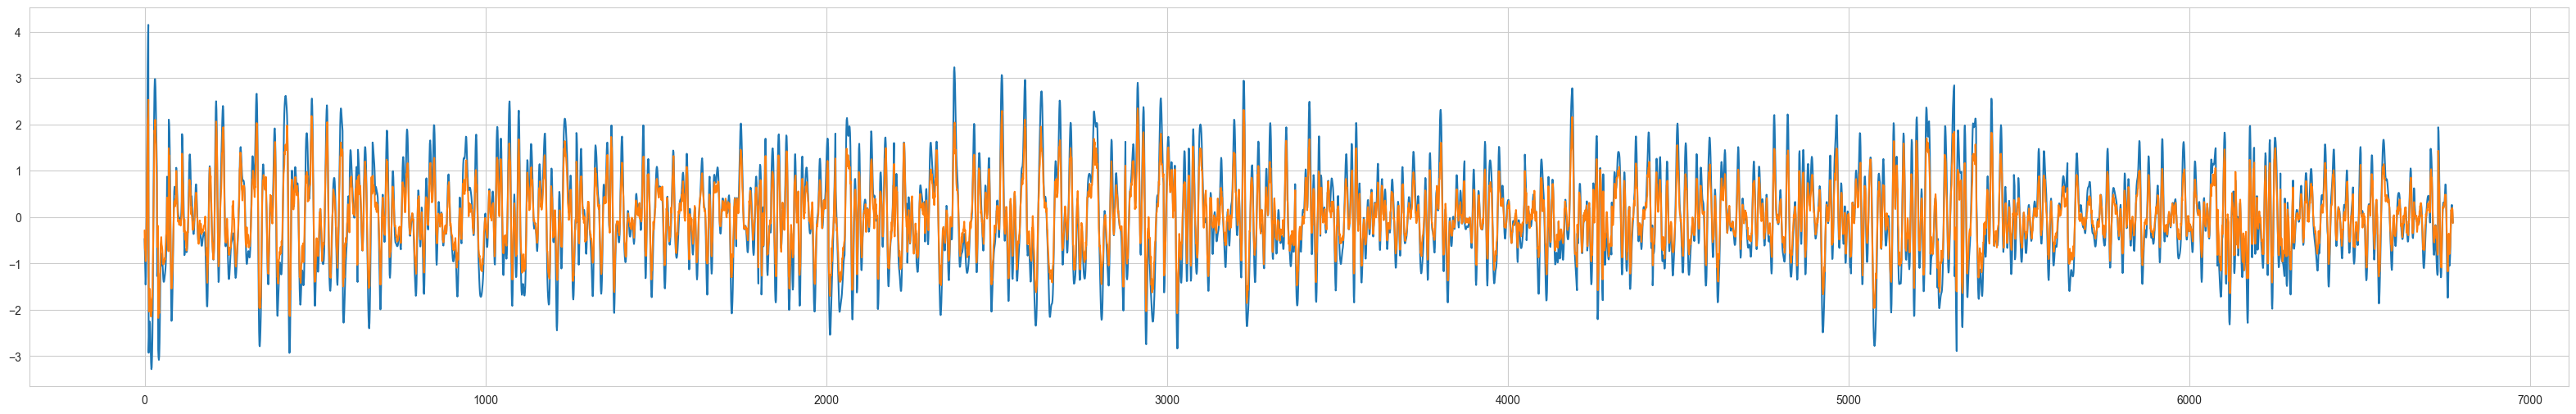

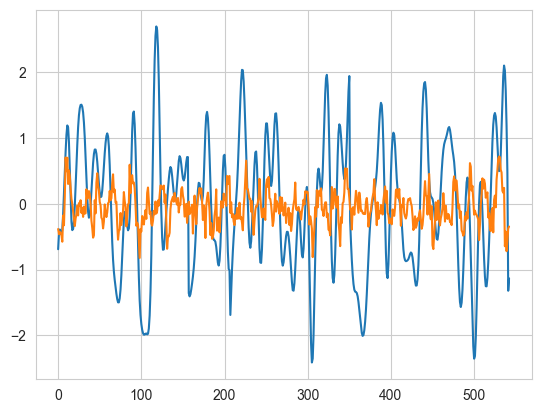

(6774, 86)
0.1068541024459475


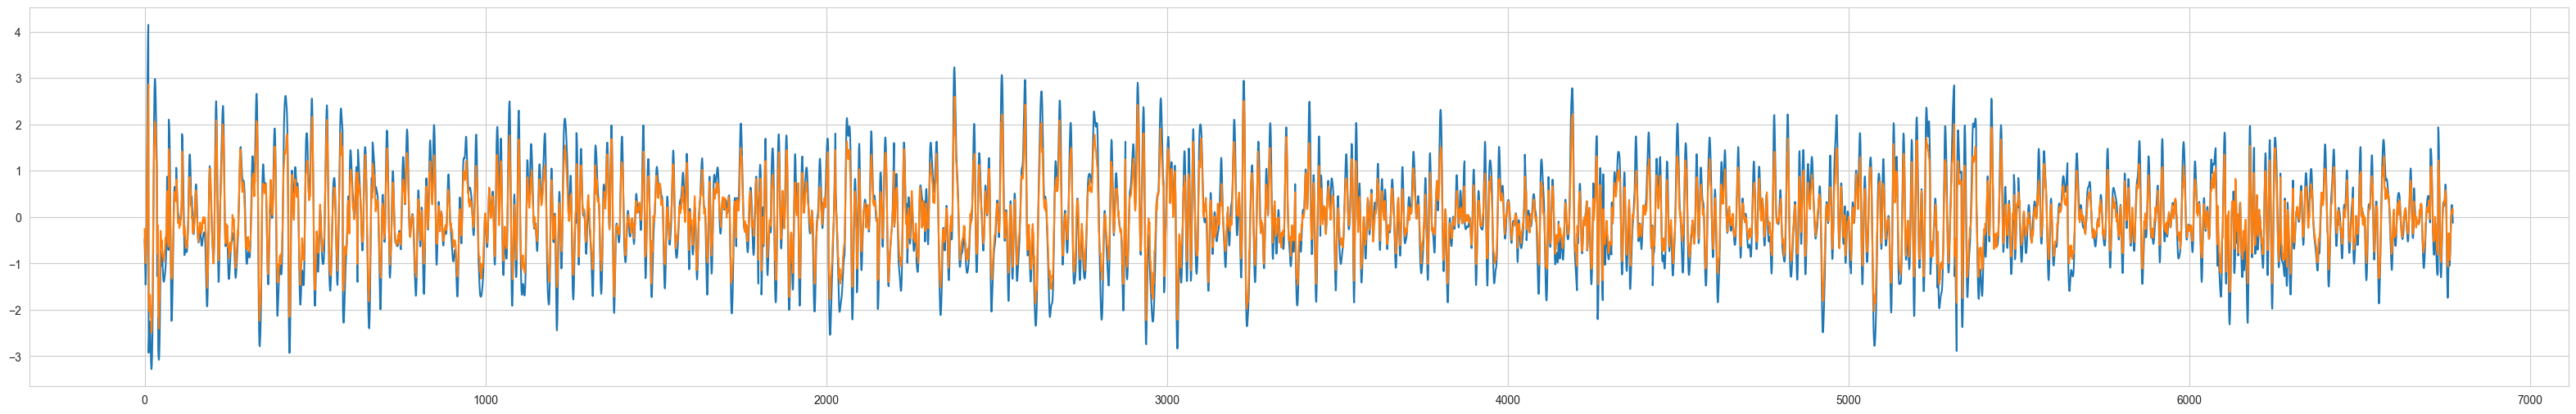

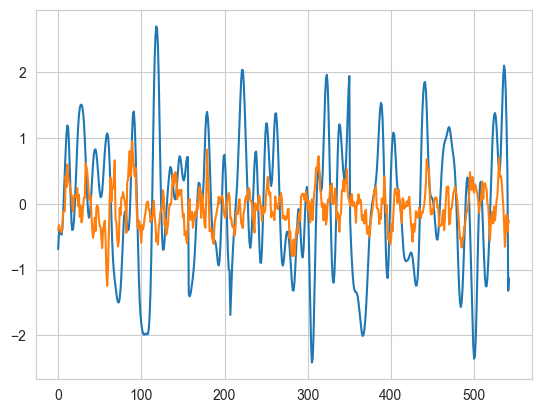

In [11]:
TEST_SUB = np.random.choice(available_subjects)
print(TEST_SUB)
for test_sub in [TEST_SUB]:
    plt.figure(figsize=(40, 6))
    print(test_sub)
    FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr = Train_Test(TEST_SUB,available_subjects,session,state,tasks_list,time = False,model = 'rf')
    print(corr)
    plt.plot(FMRI_TRAIN)
    plt.plot(ypred_train)
    plt.show()
    plt.plot(FMRI_TEST)
    plt.plot(ypred)
    plt.show()
    
    plt.figure(figsize=(40, 6))
    FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr = Train_Test(TEST_SUB,available_subjects,session,state,tasks_list,time = True,model = 'rf')
    print(corr)
    plt.plot(FMRI_TRAIN)
    plt.plot(ypred_train)
    plt.show()
    plt.plot(FMRI_TEST)
    plt.plot(ypred)
    plt.show()

[0.09463908089922335, 0.14591247101713745, -0.02659313723538914, 0.10386900140142785, 0.005152322425837297, 0.09352905358286157, 0.008359203955160321, 0.0917383837522554, 0.02507120190468959, -0.09250438396040472, 0.05030984864892862, 0.022408453078554103, 0.025664975908836873, -0.06757862974752915, 0.19763091141529798, 0.048840552688688255]
[-0.008299698323215088, 0.135657799433203, -0.08331182025036532, 0.14021438639747985, -0.0211988839445596, 0.13184127428667836, -0.20426620598589285, 0.12817529623489832, 0.020694994950551826, -0.13808707353950478, 0.05336806890027124, -0.09153615645955138, -0.06834805782010744, -0.043701865509164106, 0.08632448940008042, 0.046204114949995434]


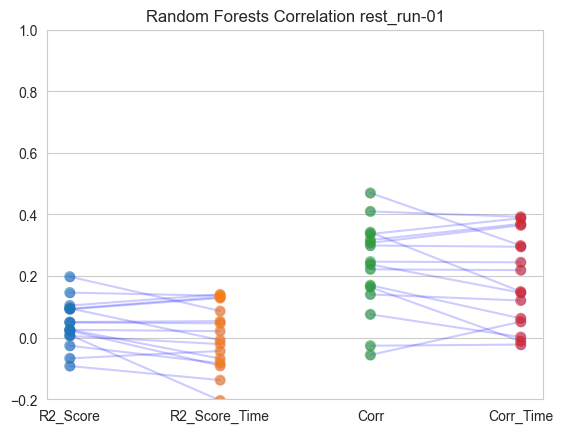

In [12]:
CORR_RF = pd.DataFrame(np.hstack((np.array(R2_score).reshape(-1,1),np.array(R2_score_TIME).reshape(-1,1),np.array(CORR).reshape(-1,1),np.array(CORR_TIME).reshape(-1,1))),columns = ['R2_Score','R2_Score_Time','Corr','Corr_Time'])
sns.stripplot(CORR_RF,s = 8,alpha = 0.6,jitter = False)
for idx, row in CORR_RF.iterrows():
    plt.plot([2, 3], [row['Corr'], row['Corr_Time']], color='blue', linestyle='-', marker='o',alpha = 0.2)
for idx, row in CORR_RF.iterrows():
    plt.plot([0, 1], [row['R2_Score'], row['R2_Score_Time']], color='blue', linestyle='-', marker='o',alpha = 0.2)
plt.xticks([0, 1,2,3],  ['R2_Score','R2_Score_Time','Corr','Corr_Time'])
plt.ylim([0,1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1])
plt.title('Random Forests Correlation '+ tasks_list[0])
print(R2_score)
print(R2_score_TIME)